In [1]:
# Transfer Learning(전이학습) 
# Kaggle brain tumor Image Classification (MRI) - Kaggle 뇌종양(Brain Tumor) 이미지 분류

In [2]:
# 1) import, GPU 설정
import torch
from torch import nn
from torchvision import models, transforms, datasets # 다양한 사전 학습 모델을 포함한 모듈
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os, shutil, zipfile, random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [3]:
# 2) 데이터 다운로드 - Kaggle brain tumor Image Classification (MRI)
# 데이터 폴더 존재시 삭제
if os.path.exists('./data/brain_tumor'):
    shutil.rmtree('./data/brain_tumor')
    print('./data/brain_tumor is removed')

./data/brain_tumor is removed


In [4]:
# 3) 압축풀기
if not os.path.exists('./data/brain_tumor.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/brain_tumor.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/brain_tumor.zip')
    with zipfile.ZipFile('./data/brain_tumor.zip', 'r') as target_file:
        target_file.extractall(os.path.join('./data', 'brain_tumor'))
        print('압축 해제 완료. ./data/brain_tumor.zip')

압축 파일 존재함. ./data/brain_tumor.zip
압축 해제 완료. ./data/brain_tumor.zip


In [5]:
# 4) 데이터 경로 설정
ROOT_DIR = './data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor_split')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [7]:
# 5) 전체 데이터셋 통합 및 재분할 함수 정의
# 현재 데이터가 train, test로 나뉘어 있으니, 두 폴더를 먼저 통합
# 전체 데이터를 클래스별로 7:1.5:1.5 비율로 train, validation, test로 다시 분할
def restructure_dataset(train_dir, test_dir, output_root, ratio=(0.7, 0.15, 0.15)):
    class_names = os.listdir(train_dir) # train 폴더의 클래스 목록 ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    for class_name in class_names:
        # 통합된 클래스별 이미지 목록
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)

        all_images = []
        if os.path.exists(train_class_path):
            all_images += [os.path.join(train_class_path, f) for f in os.listdir(train_class_path)]
        if os.path.exists(test_class_path):
            all_images += [os.path.join(test_class_path, f) for f in os.listdir(test_class_path)]

        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(ratio[0] * total)
        val_end = train_end + int(ratio[1] * total)

        splits = {
            'train': all_images[:train_end],
            'validation': all_images[train_end:val_end],
            'test': all_images[val_end:]
        }

        for split_name, split_files in splits.items():
            dst_dir = os.path.join(output_root, split_name, class_name)
            os.makedirs(dst_dir, exist_ok=True)
            for src_path in split_files:
                filename = os.path.basename(src_path)
                dst_path = os.path.join(dst_dir, filename)
                shutil.copy(src_path, dst_path)

        print(f"{class_name}: total={total}, train={len(splits['train'])}, val={len(splits['validation'])}, test={len(splits['test'])}")

# 데이터셋 재구성 실행
restructure_dataset(
    train_dir='./data/brain_tumor/train',
    test_dir='./data/brain_tumor/test',
    output_root='./data/brain_tumor_split',
    ratio=(0.7, 0.15, 0.15)
)


glioma: total=1621, train=1134, val=243, test=244
meningioma: total=1645, train=1151, val=246, test=248
notumor: total=2000, train=1400, val=300, test=300
pituitary: total=1757, train=1229, val=263, test=265


In [11]:
# 6) 데이터 전처리 설정
# train
train_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.RandomHorizontalFlip(), # 이미지 좌우반전 50% 효과
                                   transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
                                 ])
# validation
validation_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
                                 ])
# test
test_config = transforms.Compose([ transforms.Resize( (224,224) ), # 이미지 사이즈
                                   transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
                                 ])

In [12]:
# 7) 데이터셋 생성- ImageFolder 사용 → 폴더 구조 기반으로 자동 라벨링
train_dataset = datasets.ImageFolder(root=TRAIN_DATA_ROOT_DIR, transform=train_config) # train dataset
validation_dataset = datasets.ImageFolder(root=VALIDATION_DATA_ROOT_DIR, transform=validation_config) # validation dataset
test_dataset = datasets.ImageFolder(root=TEST_DATA_ROOT_DIR, transform=test_config) # test dataset

In [ ]:
# 8) 데이터로더 설정
BATCH_SIZE = 32
# num_workers=4 - 데이터를 로딩할 때 사용할 CPU 프로세스 수, 일반적으로 CPU 코어 수 / 2 또는 4~8 추천, pin_memory=True - GPU 사용 시 데이터를 고정된 메모리로 올려서 전송 속도 향상, - x.to(DEVICE) 할 때 더 빠르게 복사됨
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

torch.Size([32, 3, 224, 224]) torch.Size([32])
{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


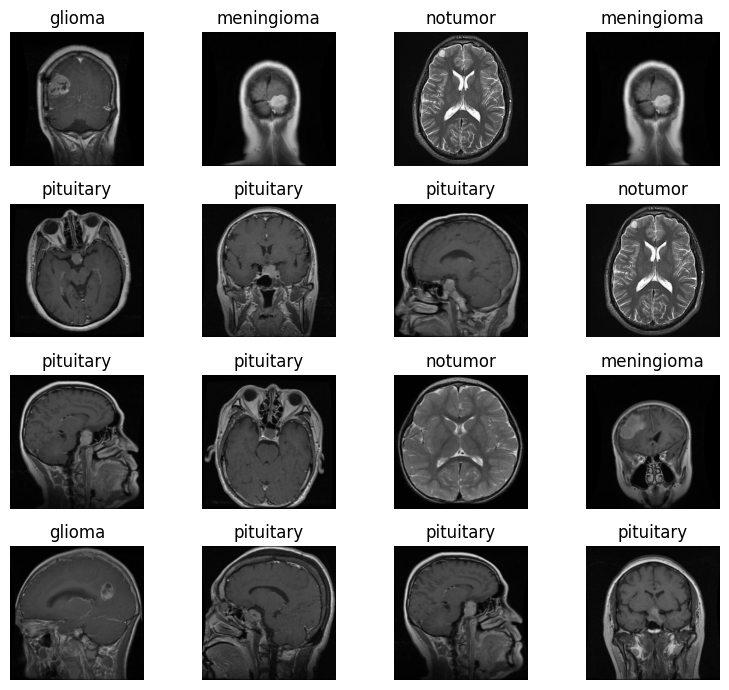

In [15]:
# 9) 데이터 확인
images, labels = next(iter(train_dataset_loader)) # - train_dataset_loader로 변경, 1개 배치 추출
print(images.shape, labels.shape)

labels_map = { v : k for k, v in train_dataset.class_to_idx.items() } # - train_dataset.class_to_idx 사용
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    # - torch.randint()는 0부터 high - 1 사이의 정수를 생성
    # - len(images)는 현재 배치에 포함된 이미지 수예요. 예를 들어 BATCH_SIZE = 32이면 len(images)는 32
    # - size = (1,) 생성할 정수의 **개수와 형태(shape)**를 지정, (1,)은 1개의 정수를 담은 1차원 텐서를 의미, 예시: tensor([17]) 결과
    sample_idx = torch.randint(len(images), size=(1, )).item() # 0~31 사이의 정수 중 하나를 랜덤하게 생성
    img, label = images[sample_idx], labels[sample_idx].item() # - 이미지와 라벨 추출

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0))) # (C, H, W) -> (H, W, C) 순서 변경
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# 10) 사전학습 모델 불러오기 - pre-trained model(사전학습모델) ViT(Vision Transfomer) 다운로드
base_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT) # Vision Transformer(ViT) 모델을 ImageNet 사전학습 가중치로 불러오는 코드
print(base_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [17]:
# 11) Transfer Learning Model
class TransferLearningModel(nn.Module):
    def __init__(self, base_model, feature_extractor):
        super().__init__()
        # ViT는 encoder.layer.N 형태로 여러 Transformer 블록을 포함하고 있으며 예를 들어 아래처럼 일부만 동결
        # - 예시) encoder.layer.0~3까지 freeze → 일반적인 특징 유지
        # - 예시) encoder.layer.4~11은 fine-tune → 데이터셋에 맞게 조정
        if(feature_extractor):
            for name, param in base_model.named_parameters():
                if 'encoder.layer.0' in name or 'encoder.layer.1' in name:
                    param.requires_grad = False  # 초기 레이어 동결
                else:
                    param.requires_grad = True   # 나머지 레이어는 학습

            # for param in base_model.parameters():
            #     param.requires_grad = False # param.requires_grad = False로 파라미터 동결 → feature extractor로만 사용할 때 필수 설정, 특정 파라미터의 기울기 계산을 중단시키는 설정, 가중치/바이어스 학습과정에서 업데이트 되지 않음
        
        base_model.heads = nn.Sequential(
            nn.Linear(base_model.heads[0].in_features, 256), # pretrained_model.heads를 새로 정의 → 기존 MLP Head를 커스터마이징하여 4개 클래스 분류에 맞춤
            nn.ReLU(), # 활성화 함수
            nn.Dropout(p=0.5), # 드롭아웃
            nn.Linear(256, 64), # 은닉층
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(64, 4) # 최종 출력층 - 4가지 brain tumor 분류(classification)
        )
        self.model = base_model
    
    def forward(self, x):
        x = self.model(x) # - 사전학습된 모델의 순전파 메서드 호출
        return x

In [18]:
# 12) 모델, 손실함수, 옵티마이저 객체생성 및 하이퍼라마미터 설정
feature_extractor = False # - feature_extractor = False → fine-tuning 모드로 전체 모델 학습
model = TransferLearningModel(base_model=base_model, feature_extractor=feature_extractor).to(DEVICE) # - model 객체 생성
loss_function = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer

print(model) # - 모델 구조 출력

TransferLearningModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (

In [19]:
# 13) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0 # train loss 합
    train_correct = 0 # train 맞춘 개수
    train_total = 0 # train 전체 개수
    total_train_batch = len(dataloader) # 전체 배치 개수
    for images, labels in dataloader: # dataloader에서 배치 단위로 이미지와 라벨 추출        
        x_train = images.to(DEVICE) # GPU로 데이터 전송
        y_train = labels.to(DEVICE)
        
        outputs = model(x_train) # 모델 예측
        loss = loss_function(outputs, y_train) # 손실함수 계산

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item() # 오차 누적
        train_total += y_train.size(0) # 배치 내 샘플 개수 누적
        train_correct += (torch.argmax(outputs, dim=1) == y_train).sum().item() # - argmax로 예측값과 실제값 비교 후 맞춘 개수 누적
        
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [20]:
# 14) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)
        for images, labels in dataloader:            
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, dim=1) == y_val).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [21]:
# 15) Model test 함수
def model_test(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)
        for images, labels in dataloader:            
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == y_test).sum().item()
            
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)
        return test_avg_loss, test_avg_accuracy


In [22]:
# 16) Confusion Matrix(혼동행렬) 시각화 함수
def confusion_matrix_plot(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    cm = confusion_matrix(all_labels, all_preds) # 혼동행렬(Confusion Matrix) 계산
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[labels_map[i] for i in range(len(labels_map))]) # - display_labels에 클래스 이름 전달
    plt.figure(figsize=(8, 6)) # - 그래프 크기 설정
    disp.plot(cmap=plt.cm.Blues) # - 블루 계열의 컬러맵 사용
    plt.xticks(rotation=45) # x축 라벨 45도 회전
    plt.title('Confusion Matrix') # - 타이틀 추가
    plt.show()

In [23]:
# 17) Classification Report 함수
def classification_report_plt(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    target_names = list(labels_map.values()) # - 클래스 이름 리스트 생성
    report = classification_report(all_labels, all_preds, target_names=target_names, digits=4) # - 분류 리포트 생성, digits=4로 소수점 4자리까지 출력 → 정밀한 비교 가능

    print(report) # - 분류 리포트 출력

In [25]:
# 18) Model 학습 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
start_time = datetime.now()
EPOCHS = 20

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader, model=model, loss_function=loss_function, optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader, model=model, loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    
    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.582420 , train acc =  82.641433 val loss =  0.260584 , val acc =  92.585551
epoch :  02 train loss =  0.238723 , train acc =  93.691494 val loss =  0.200106 , val acc =  93.536122
epoch :  03 train loss =  0.155144 , train acc =  95.767196 val loss =  0.205855 , val acc =  93.631179
epoch :  04 train loss =  0.139166 , train acc =  96.174196 val loss =  0.195342 , val acc =  94.391635
epoch :  05 train loss =  0.109993 , train acc =  96.967847 val loss =  0.146327 , val acc =  96.007605
epoch :  06 train loss =  0.100942 , train acc =  97.313797 val loss =  0.159915 , val acc =  95.627376
epoch :  07 train loss =  0.070159 , train acc =  98.371998 val loss =  0.081868 , val acc =  98.003802
epoch :  08 train loss =  0.056390 , train acc =  98.636549 val loss =  0.090243 , val acc =  97.338403
epoch :  09 train loss =  0.056146 , train acc =  98.677249 val loss =  0.152803 , val acc =  95.247148
epoch :  10 train loss =  0.074008 , train acc =  98.209198 val 

In [26]:
# 19) 테스트 데이터셋 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, model=model, loss_function=loss_function)

accuracy =  98.01324503311258 , loss =  0.085527197498911


(0.085527197498911, 98.01324503311258)

<Figure size 800x600 with 0 Axes>

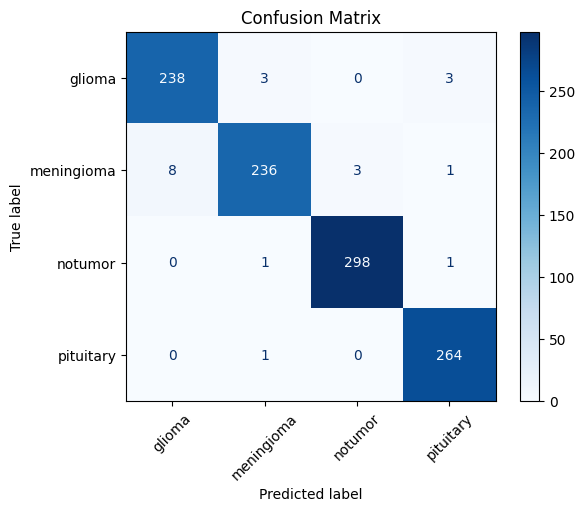

In [27]:
# 20) Confusion Matrix(혼동행렬) 시각화
confusion_matrix_plot(dataloader=test_dataset_loader, model=model)

In [28]:
# 21) clssification report 출력
classification_report_plt(dataloader=test_dataset_loader, model=model)

              precision    recall  f1-score   support

      glioma     0.9675    0.9754    0.9714       244
  meningioma     0.9793    0.9516    0.9652       248
     notumor     0.9900    0.9933    0.9917       300
   pituitary     0.9814    0.9962    0.9888       265

    accuracy                         0.9801      1057
   macro avg     0.9795    0.9791    0.9793      1057
weighted avg     0.9801    0.9801    0.9801      1057



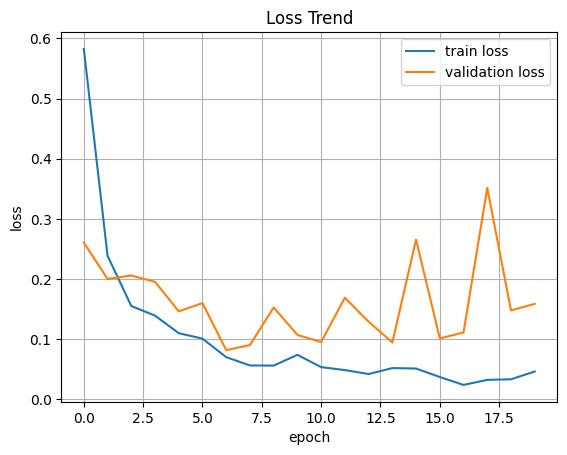

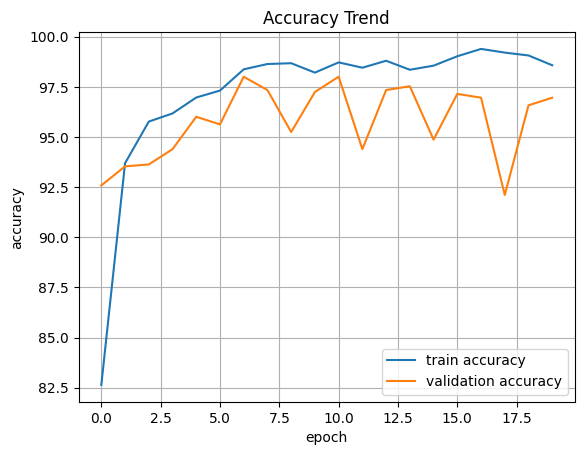

In [29]:
# 22) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [30]:
# 23) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_transfer_learning_brain_tumor_mri.ckpt')

In [31]:
# 24) 테스트 - 모델 추론 및 예측값 추출
BATCH_SIZE = 32

# test dataloaer 생성
test_image_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_images, test_labels = next(iter(test_image_loader)) # 1개 배치 추출

x_test = test_images.to(DEVICE) # - GPU로 데이터 이동
y_test = test_labels.to(DEVICE)

outputs = model(x_test) # 모델 추론
_, preds = torch.max(outputs, 1) # 모델 예측값 추출

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


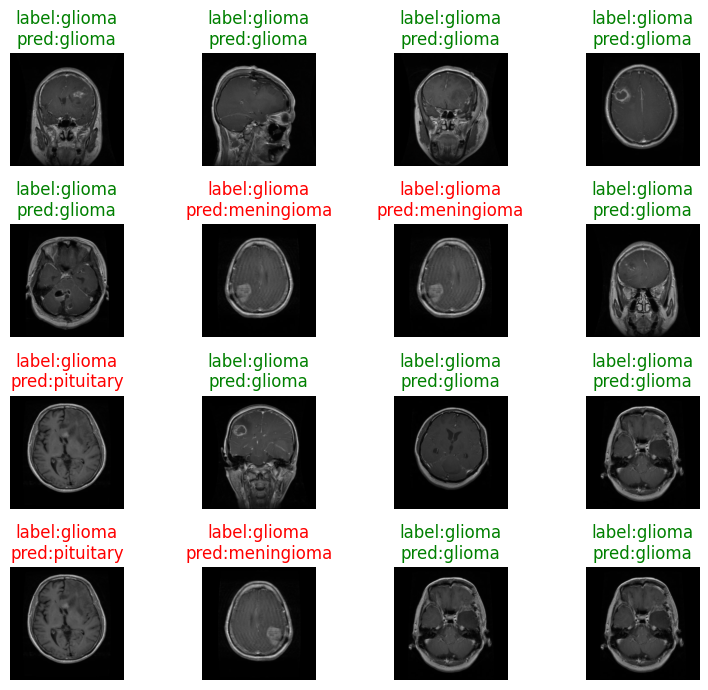

In [32]:
# 25) 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    img = img.clamp(0, 1) # 0~1 사이의 값으로 클램핑

    correct = (label == pred) # 정답 여부
    title_color = 'green' if correct else 'red' # 정답이면 녹색, 오답이면 빨간색
    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred], color=title_color) # - 정답이면 녹색, 오답이면 빨간색 타이틀 출력
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()